In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pylab

X, _ = make_moons(n_samples=5000, random_state=42, noise=0.1)

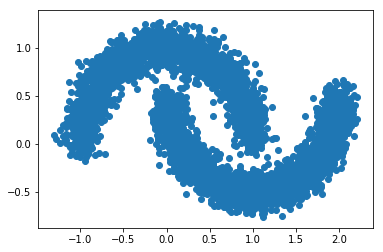

In [2]:
pylab.scatter(X[:,0], X[:,1])
pylab.show()

In [3]:
# Import the torch functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


In [4]:
# Define the z (the random input to the GAN)
def z(n):
    return torch.Tensor(np.random.normal(0, 1, (n,2)))  # Gaussian

In [5]:
# Generator
g_input_size = 2     # Dimension of random noise given to generator
g_hidden_size = 50   # Number of hidden units of the generator complexity
g_output_size = 2    # size of generated output vector

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.layer1(x)) # ELU activations are like ReLU activations but without zero gradients for ELU(x), x < 0.
        x = F.sigmoid(self.layer2(x))
        return self.layer3(x)

In [6]:
# Generator creation
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)

g_learning_rate = 2e-4
optim_betas = (0.9, 0.999)

g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)


In [7]:
# Discriminator (classifier) creation
# Define the mini-batch sizes
minibatch_size = 100

d_input_size = 2     # Input to the discriminator (will determine 'real' or 'fake')
d_hidden_size = 50   # Number of hidden units of the discriminator
d_output_size = 1    # Output of discriminator for 'real' vs. 'fake' classes


class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.elu(self.layer1(x))
        x = F.elu(self.layer2(x))
        return F.sigmoid(self.layer3(x))

In [8]:
D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)

# Negative log-likelihood loss (aka, cross-entropy loss) for binary classes (fake, real)
loss = nn.BCELoss() 

d_learning_rate = 2e-4
optim_betas = (0.9, 0.999) # paramters specific to Adam optimnization (not part of this lecture)

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)

In [9]:
D.zero_grad()

#  Train D on real data
d_real_data = Variable(torch.FloatTensor(X[0:minibatch_size,:]))
d_real_decision = D(d_real_data)

print(d_real_decision[0:3,:])

Variable containing:
 0.5143
 0.5093
 0.5092
[torch.FloatTensor of size 3x1]



In [10]:
d_real_error = loss(d_real_decision, Variable(torch.Tensor([[1]]*100)))  # ones = true data
d_real_error.backward() # store gradients, but don't change params yet because we are not done with the examples

In [11]:
d_gen_input = Variable(z(minibatch_size)) # Input to the Generator
d_fake_data = G(d_gen_input).detach()  # Generate outputs and detach to avoid training the Generator on these labels... 
                                       # ...just get the examples
d_fake_decision = D(d_fake_data)  # Perform a foward pass using the fake data
print(d_fake_decision[0:3,:]) # print the decitions

Variable containing:
 0.5010
 0.5024
 0.5021
[torch.FloatTensor of size 3x1]



In [12]:
d_fake_error = loss(d_fake_decision, Variable(torch.Tensor([[0]]*100)))  # zeros = fake
d_fake_error.backward() # this will append the gradients of these examples to the 
                          # previous gradients (computed over the real data)

In [13]:
d_optimizer.step()     # Only optimizes Discriminator's parameters; 
                      #   the updates are based on the stored gradients from backward()

In [14]:
G.zero_grad() # must zero the Generator gradient

d_gen_input = Variable(z(minibatch_size))
d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels

In [15]:
dg_fake_decision = D(d_fake_data)

# we want to fool the classifier, so pretend it's all real data and we will train G to 
#   minimize this loss (maximize the likelihood of getting the fake data to have labels "1" (true data))
g_error = loss(dg_fake_decision, Variable(torch.Tensor([[1]]*100)))  

g_error.backward() # Get Generator gradients

g_optimizer.step()  # Only optimizes G's parameters

In [16]:
num_epochs = 2000

d_steps = 100 # number of gradient steps of discriminator per minibatch
g_steps = 100 # number of gradient steps of generator per minibatch

print_interval = 10
batch_no = 0

for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train Discriminator on real+fake

        D.zero_grad()

        #  Train D on real data
        d_real_data = Variable(torch.FloatTensor(X[(batch_no*minibatch_size):((batch_no+1)*minibatch_size),:]))
        d_real_decision = D(d_real_data)
        d_real_error = loss(d_real_decision, Variable(torch.Tensor([[1]]*100)))  # ones = true data
        d_real_error.backward() # store gradients, but don't change params yet
        
        batch_no += 1
        if batch_no >= 5000/minibatch_size:
            batch_no = 0
        
        d_gen_input = Variable(z(minibatch_size))
        d_fake_data = G(d_gen_input).detach()  # Generate outputs and detach to avoid training the Generator on these labels
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss(d_fake_decision, Variable(torch.Tensor([[0]]*100)))  # zeros = fake data
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D based on stored gradients from both backwards

    for g_index in range(g_steps):
        # 2. Train Generator on Discriminator's response (but WE WILL NOT train Discriminator on these labels)
        G.zero_grad()

        d_gen_input = Variable(z(minibatch_size))
        d_fake_data = G(d_gen_input)  # we will be training G on these labels
        dg_fake_decision = D(d_fake_data)
        g_error = loss(dg_fake_decision, Variable(torch.Tensor([[1]]*100)))  # we want to fool, so pretend it's all genuine
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    if epoch % print_interval == 0:
        print("%s" % (epoch))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


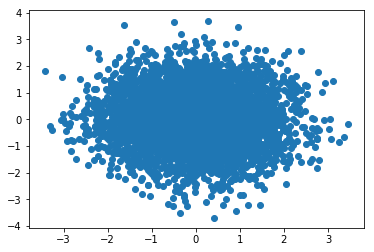

In [17]:
noise = z(5000).numpy()

pylab.scatter(noise[:,0], noise[:,1])
pylab.show()

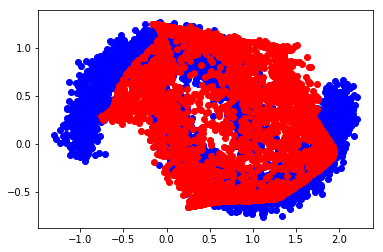

In [18]:
d_gen_input = Variable(z(5000))
d_fake_data = G(d_gen_input).detach().data.numpy()

pylab.scatter(X[:,0], X[:,1],c="blue")
pylab.scatter(d_fake_data[:,0], d_fake_data[:,1],c="red")
pylab.show()